# Painting the EoR

Now we finally come to the point when we start to plot the ionizing regions.

To recap. At this point we have the following data:
* Initial (linear) density field
* Scalar density field an multiple redshifts
* Halo catalogs

In [1]:
# we start with importing all necessary components
%matplotlib inline

import numpy as np
from numpy import sin, cos, pi

import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML

from scipy.stats import rankdata, norm

# FastPM related libraries to work with snapshots
from nbodykit.source.catalog.file import BigFileCatalog
from nbodykit.source.mesh import BigFileMesh

from nbodykit.cosmology import Planck15
from nbodykit.cosmology import EHPower

from nbodykit.lab import *
from nbodykit import setup_logging, style

from skimage import measure

/home/kaurov/anaconda3/envs/cfastpm/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
from reionprimer import *

We start from where we left in the previous notebook. Loading the ICs.

In [8]:
N = 128
boxsize = 10.

part = BigFileCatalog('fastpm_0.0196', dataset='1/', header='Header')
ic = part.to_mesh(Nmesh=N).to_field()
ic = np.array(ic)

f_ic = np.fft.rfftn(ic)

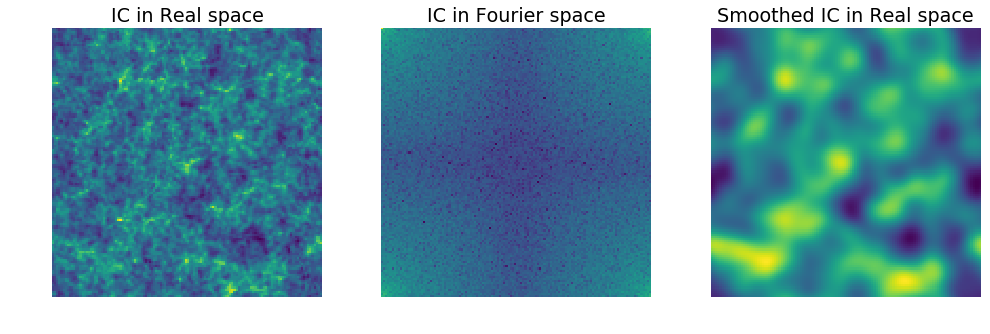

In [9]:
plt.figure(figsize=(14,6))
plt.subplot(131)
plt.imshow(ic[0,:,:])
plt.axis('off')
plt.title('IC in Real space')
plt.subplot(132)
plt.imshow(np.log10(np.abs(f_ic[:,:,0])))
plt.axis('off')
plt.title('IC in Fourier space')
plt.subplot(133)
plt.imshow(smooth(f_ic, 4, 128, 'gaussian')[0,:,:])
plt.axis('off')
plt.title('Smoothed IC in Real space')

plt.tight_layout()

## What is trajectory?

Trajectory for a given point (Eulerian) in space for a scalar field $A$ is a 1D function, which gives the value of smoothed field $A$ at this point as a function of smoothing scale.

In [10]:
from scipy.stats import norm

def get_trajectories(field, 
                     sm_scales=np.array([1,2,4,8,16,32,64,128,256], dtype=float), 
                     filter_mode='gaussian', 
                     normalization='None'):
    """Generating 'trajectories' for the 3D field

    Args:
        field (3d float array):  Original neutral fraction field of IGM.
        sm_scales (float array): List of smoothing scales.
        filter_mode     (str):   Coefficient.
        normalization (str):     For each smoothing scale we can normalize the 
                                 resulting smooth field. Options are: 
                                 'None' - do nothing.
                                 'rankorder' - assign to the cell its order 
                                              (result is the uniform distribution 
                                              between 0 and 1)
                                 'gaussian' - same as above, but the distribution 
                                              is normal with mean = 0 and std = 1

    Returns:
        res: [N x N x N x len(sm_scales)] array of trajectories.

    """
    f_field = np.fft.rfftn(field)
    N = field.shape[0]
    res = np.zeros([N,N,N,len(sm_scales)])
    for i,scale in enumerate(sm_scales):
        res[:,:,:,i] = smooth(f_field, scale, N, mode=filter_mode)
        if normalization == 'rankorder':
            res[:,:,:,i] = rankdata(res[:,:,:,i].reshape([N**3]), method='ordinal').reshape([N,N,N])
            res[:,:,:,i] = res[:,:,:,i]/(N**3-1)
        if normalization == 'gaussian':
            res[:,:,:,i] = rankdata(res[:,:,:,i].reshape([N**3]), method='ordinal').reshape([N,N,N])
            res[:,:,:,i] = res[:,:,:,i]/(N**3-1)
            res[:,:,:,i] = norm.ppf(res[:,:,:,i], loc=0, scale=1)
#             res[:,:,:,i] -= res[:,:,:,i].mean()
#             res[:,:,:,i] /= res[:,:,:,i].std()
    return res

In [11]:
sm_scales=np.array([1,2,4,8,16,32,64,128,256])
field = get_trajectories(ic, sm_scales=sm_scales, filter_mode='tophat', normalization='gaussian')

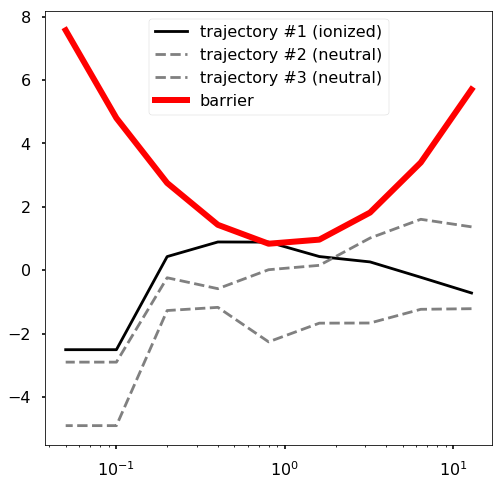

In [15]:
def barrier(s):
    return 4.*(np.log10(s)+0.)**2+0.8

temp_x = N/sm_scales/boxsize
plt.figure(figsize=(8,8))
plt.plot(temp_x, field[0,100,40,:], '-', c='k', label='trajectory #1 (ionized)')
plt.plot(temp_x, field[0,0,0,:], '--', c='gray', label='trajectory #2 (neutral)')
plt.plot(temp_x, field[0,30,100,:], '--', c='gray', label='trajectory #3 (neutral)')
plt.plot(temp_x, barrier(temp_x), linewidth=6, c='r', label='barrier')
plt.legend()
plt.xscale('log')

In [16]:
ion = np.zeros([N,N,N])
for i,scale in enumerate(sm_scales):
    ion[field[:,:,:,i] > barrier(N/scale/boxsize)] = 1

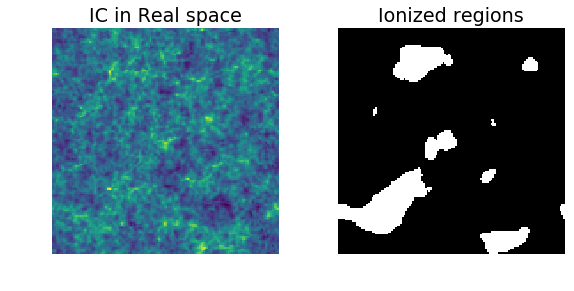

In [17]:
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.imshow(ic[0,:,:])#.sum(2))
plt.axis('off')
plt.title('IC in Real space')
plt.subplot(132)
plt.imshow(ion[0,:,:],cmap='gray')
plt.axis('off')
plt.title('Ionized regions')

plt.tight_layout()

___
#### Comment on the origins of barrier

The shape of the barrier, which we took arbitrary for the purpose of illustration in this notebook, can be calculated using some physical assumptions and parametrized with some physically-motivated variables. In the original paper by [Fulanetto et al. (2004)](https://ui.adsabs.harvard.edu/#abs/2004ApJ...613....1F/abstract) the parametrization is $\zeta$, $\sigma_\mathrm{min}$ and $z$ that correspond to the efficieny of producing ionizing photons, minimum scale/mass of star formation region ($T_\mathrm{vir} < 10^4 K$) and redshift.

There are many extensions of this physical model. I personally wrote a couple of papers on extending this model with [halo bias and LLS](https://ui.adsabs.harvard.edu/#abs/2013ApJ...771...35K/abstract) and [recombination clumping factor](https://ui.adsabs.harvard.edu/#abs/2014ApJ...787..146K/abstract). My personal view to this problem is that ultimately we want to fit the parameters of the semi-analytical models (based on the excusion set formalism, bias expansion, etc) into our best, most  complete, numerical simulation; and then use the semi-analytical model to probe larger volumes and wider parameter spaces. I discuss this approach in [Kaurov (2016)](https://ui.adsabs.harvard.edu/#abs/2016ApJ...831..198K/abstract).


#### DIY

* Implement the shape of the barrier from [Fulanetto et al. (2004)](https://ui.adsabs.harvard.edu/#abs/2004ApJ...613....1F/abstract).

___

## Model with halos

In previous section we used only the ICs. One can rightfully argue that the bubbles should form only around the halos with stars. Therefore, it is logical to use the density of stars (or halos) instead of simly DM density.

Luckly we have the halo catalog. The routines provided with FastPM allows us to quickly find halos using Friends-of-Friends algorithm.

In [19]:
# We load again the snapshot of the DM particles and project the density onto the 3D grid 'q'

part = BigFileCatalog('fastpm_0.1250', dataset='1/', header='Header')
q = part.to_mesh(Nmesh=N)
q = q.to_field()

In [20]:
# Also, we load the catalog of DM halos that we generated in the section 'Preparations'

halos = BigFileCatalog('fastpm_0.1250/fof/0.200/',header='Header')
# ic = part.to_mesh(Nmesh=128).to_field()
# ic = np.array(ic)

/home/kaurov/anaconda3/envs/cfastpm/lib/python3.5/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in log10
  return func(*args2)


Text(0,0.5,'N')

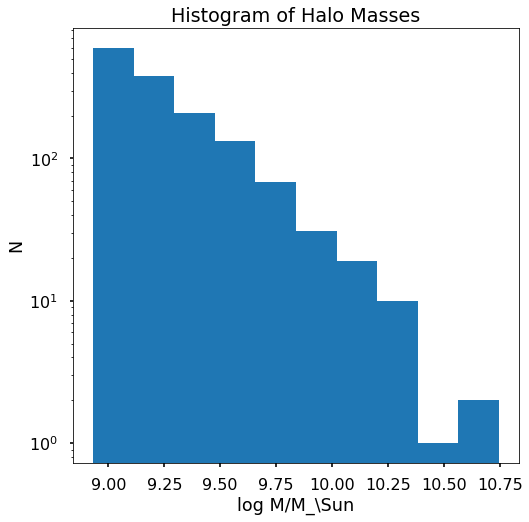

In [21]:
# Here is a plot of the mass fuction

plt.figure(figsize=(8,8))
plt.hist(np.log10(halos['Mass'])[1:])
plt.title('Histogram of Halo Masses')
plt.yscale('log')
plt.xlabel('log M/M_\Sun')
plt.ylabel('N')

(0, 128)

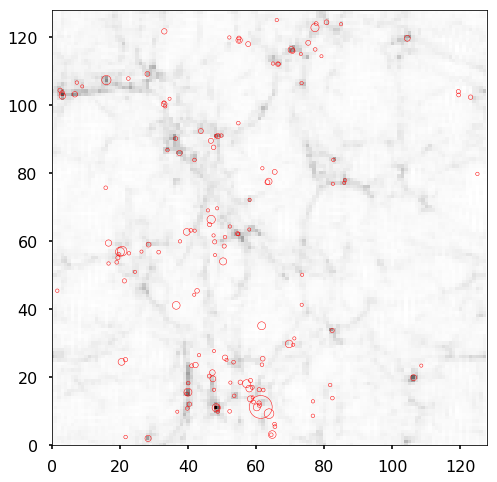

In [22]:
# Next overplot halos on top of the density field in a slice.

M = np.array(halos['Mass'])
pos = np.array(halos['CMPosition'])

# Filter only halos of given mass and located in a slice
filt = (M>10**9.) & (pos[:,0]>0) & (pos[:,0]<2)

plt.figure(figsize=(8,8))
plt.imshow(q[:10,:,:].sum(0), cmap='gray_r')
plt.scatter(pos[filt,2]/ boxsize*N, pos[filt,1] / boxsize*N, s=(M[filt]/1e9)*10., edgecolor='r', facecolor='None')

plt.xlim([0,N])
plt.ylim([0,N])

One can come up with multiple recepies for assigning the number of ionizing photons per halo. Here we assume that it is proportional to the mass, and that halos below some $M_{crit} = 10^{9} M_\odot$ do not form stars.

In [24]:
# we want to take only halos above 10^10 M_\Sun
filt = (M>1e9)

halo_field_m = np.zeros([N,N,N])

for i,(m,x,y,z) in enumerate(zip(M[filt],
                                 (pos[filt,0])/boxsize*N, 
                                 (pos[filt,1])/boxsize*N, 
                                 (pos[filt,2])/boxsize*N)):
    halo_field_m[int(x),int(y),int(z)] += 1.0 * m


# halo_field += q*1e10

In [25]:
# We add the density fild multiplied by a small constant in order to avoid numerical singularities in the future.

halo_field = halo_field_m + q*1e-2

Text(0.5,0,'Mpc/h')

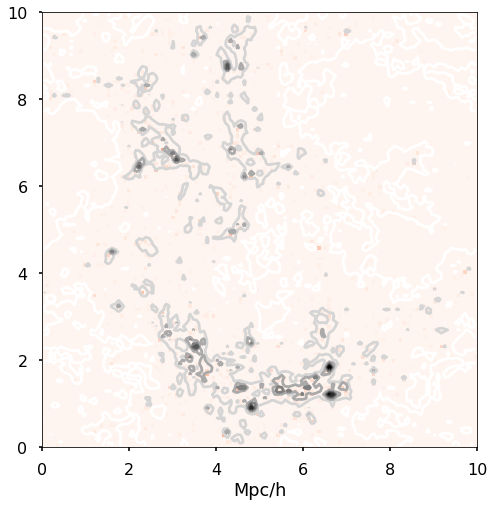

In [26]:
# quick check that halos follow the density field

plt.figure(figsize=(8,8))
plt.imshow(halo_field[:,:,:].sum(0),extent=(0,boxsize,0,boxsize), cmap='Reds', origin='lower')
plt.contour((q[:,:,:].sum(0)),extent=(0,boxsize,0,boxsize), cmap='gray_r', origin='lower')

plt.xlim([0,boxsize])
plt.ylim([0,boxsize])

plt.xlabel('Mpc/h')

In [27]:
field = get_trajectories(halo_field, filter_mode='gaussian', normalization='rankorder')

(0, 1.5)

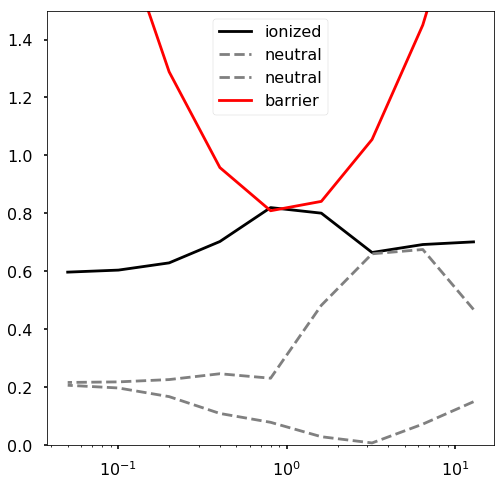

In [28]:
def barrier(s):
#     return s*0 + 0.9
    return 1*(np.log10(s)+0.0)**2+0.8

temp_x = N/sm_scales/boxsize
plt.figure(figsize=(8,8))
plt.plot(temp_x, field[0,100,40,:], '-k', label='ionized')
plt.plot(temp_x, field[0,0,0,:], '--', c='gray', label='neutral')
plt.plot(temp_x, field[0,30,100,:], '--', c='gray', label='neutral')
plt.plot(temp_x, barrier(temp_x), 'r', label='barrier')

plt.legend()
plt.xscale('log')
plt.ylim([0,1.5])

In [29]:
ion = np.zeros([N,N,N])
for i,scale in enumerate(sm_scales):
    ion[field[:,:,:,i] > barrier(N/scale/boxsize)] = 1

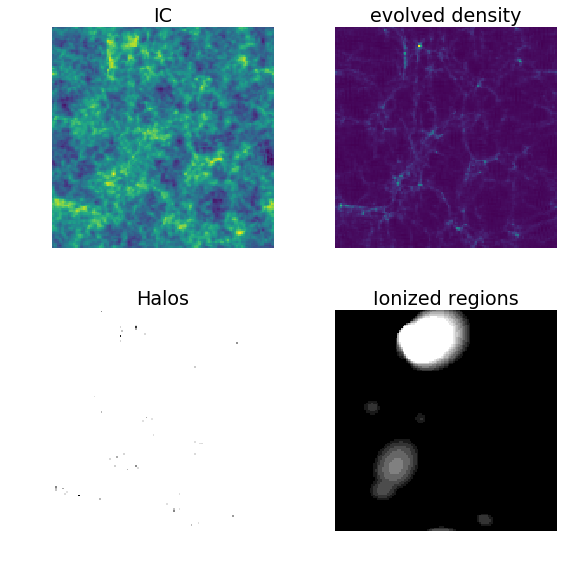

In [30]:
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(ic[:10,:,:].sum(0))
plt.axis('off')
plt.title('IC')
plt.subplot(222)
plt.imshow(q[:10,:,:].sum(0))
plt.axis('off')
plt.title('evolved density')
plt.subplot(223)
plt.imshow(halo_field[:10,:,:].sum(0),cmap='gray_r')
plt.axis('off')
plt.title('Halos')
plt.subplot(224)
plt.imshow(ion[:10,:,:].sum(0),cmap='gray')
plt.axis('off')
plt.title('Ionized regions')

plt.tight_layout()

### Reionization field

Now we would like to simulate not only the state of the reionization at a single redshift, but full history. Again, we will do it completely in a model agnostic way. We do not adopt any phtsical model, we use a moving barrier insted.

In [31]:
def barrier(s, h):
#     return s*0 + 0.9
    return 4*(np.log10(s)+0.0)**2+h

def r_barrier(s, v):
    return v-4*(np.log10(s)+0.0)**2

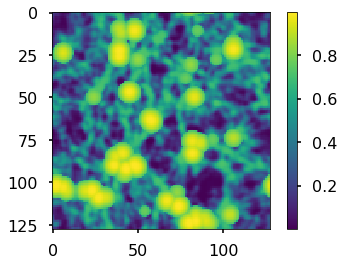

In [32]:
plt.imshow(field[0,:,:,0])
plt.colorbar()

We look for the largest h, for with each cell is ionized. Later we will rank order the cells according to h and will derive redshift from it.

In [34]:
h_field = np.zeros([N,N,N,len(sm_scales)])
for i,scale in enumerate(sm_scales):
    h_field[:, :, :, i] = r_barrier(N/scale/boxsize, field[:,:,:,i])

h_field = h_field.max(3)
print(h_field.shape)
    


(128, 128, 128)


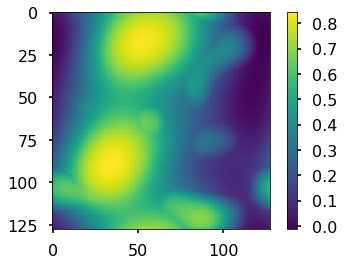

In [35]:
plt.imshow(h_field[0,:,:])
plt.colorbar()

Now we need to come up with some reionization history, and match our simulation exactly to that history.

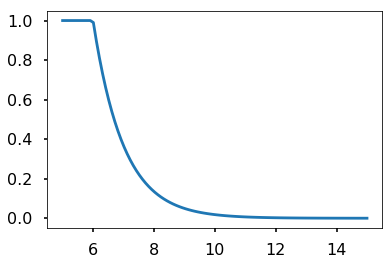

In [41]:
def convert_to_h_field(h_field, z_list, f_list):
    """Converting any ordered field to match given reionization field.
    
    """
    f_field = 1.0-(rankdata(h_field) / N**3).reshape([N,N,N])
    z_field = np.interp(f_field.flat, f_list, z_list).reshape([N,N,N])
    return f_field, z_field

def reion_history(z):
    res = np.exp((6-z)/1.)
    res[z<6] = 1.0
#     res = np.arctan((8.-z)*5.)/np.pi+0.5
    return res

z_list = np.linspace(15,5,100)
f_list = reion_history(z_list)

plt.plot(z_list, f_list)

In [42]:
f_field, z_field = convert_to_h_field(h_field, z_list, f_list)

Text(0,0.5,'Number of cells ionized at given redhsift')

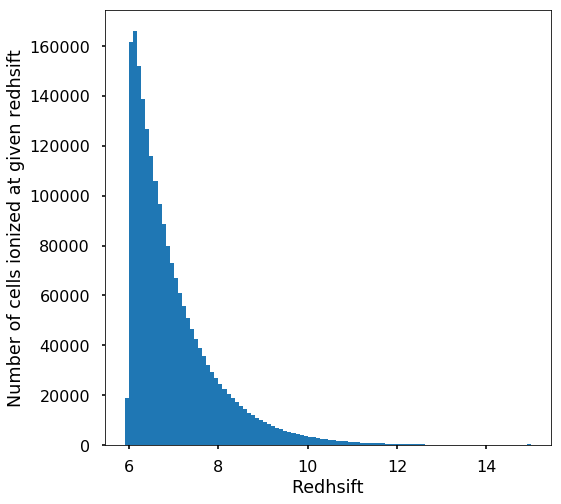

In [43]:
plt.figure(figsize=(8,8))
temp = plt.hist(z_field.flatten(),100)
plt.xlabel('Redhsift')
plt.ylabel('Number of cells ionized at given redhsift')

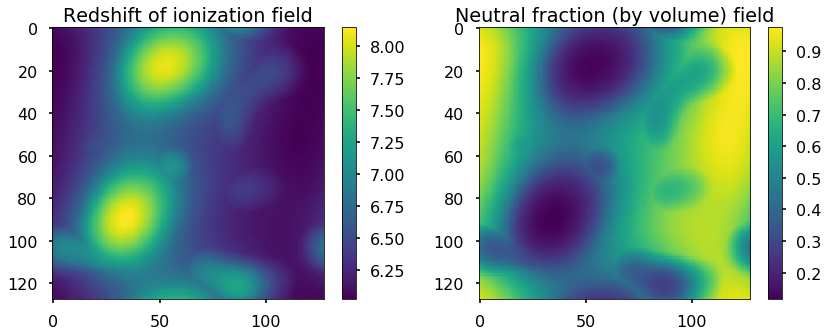

In [44]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.imshow(z_field[0,:,:])
plt.title('Redshift of ionization field')
plt.colorbar()
plt.subplot(122)
plt.imshow(f_field[0,:,:])
plt.title('Neutral fraction (by volume) field')
plt.colorbar()

___
#### DIY

* We used only one redshift snapshot for defining halos. One can easily improve the code by using appropriate halo catalogs at each redshift.
* Since we have multiple fields -- halo density, DM density -- one can come up with a better estimator.
* One can try to improve the barrier approach by using more sophisticated function. However, one should remember that one of the benefits of a moving barrier is its smoothemess, i.e. the regions become ionized subsecuently from halos outwards.
* We defined inonization history by setting the ionization fraction of the **volume**. However, the fraction weighted by **mass** is more physical, since the global optical depth, $\tau$, is proportional to the total number of free electrons. One can easily modify the rank ordering function and fix this issue.
___